# Coursework 2: Clinical image classification

In this coursework, we will work on a clinical imaging dataset. The dataset comes from [ISIC (International Skin Imaging Collaboration) 2016 Challenge](https://challenge.kitware.com/#challenge/560d7856cad3a57cfde481ba). It consists of 900 skin lesion images, categorised into two classes: malignant (melanoma) and benign, as shown here.

![](melanoma_vs_benign.jpg)

To faciliate this coursework, we have pre-processed the images for you, including resizing the original images to a standard size of 64 by 64, splitting into a training set and a test set, so you simply need to focus on the visualisation and classification work. Your task here is to read the imaging data and train a model that classifies between benign and malignant images.

Hint: This coursework is similar to the hand digit classification problem you have just learnt at class. It is a transition from data management to data analysis. You will use a machine learning library, sklearn, and we have provided guidance in this coursework. We will assess the proper implementation of the whole pipeline, but not the classification accuracy. Just have fun!

In the next term, you will learn more about machine learning, what each of the model mentioned here does and how to improve the classification performance.

In [1]:
# Load the libraries (provided)
import os
import imageio
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sklearn
from sklearn import neighbors, ensemble, svm, metrics

## 1. Load and visualise data.

#### 1.1 Load the spreadsheets `training.csv` and `test.csv`. Print the first few lines. Check how many benign and malignant cases there are in training and test sets. (15 points)

In [6]:
y_train_df=pd.read_csv("training.csv")
y_test_df=pd.read_csv("test.csv")
print("The first few lines of the training set are: \n \n{} \n\nThe first few lines of the test set are: \n\n{}". format(y_train_df.head(5), y_test_df.head(5)))

The first few lines of the training set are: 
 
     Unnamed: 0      label
0  ISIC_0000500     benign
1  ISIC_0010086     benign
2  ISIC_0010455     benign
3  ISIC_0009188     benign
4  ISIC_0011348  malignant 

The first few lines of the test set are: 

     Unnamed: 0      label
0  ISIC_0011295  malignant
1  ISIC_0000292  malignant
2  ISIC_0004715     benign
3  ISIC_0000077     benign
4  ISIC_0010357     benign


In [7]:
print("The number of benign and malignant cases in the train set are:\n{}".format(y_train_df["label"].value_counts()))

The number of benign and malignant cases in the train set are:
benign       489
malignant    111
Name: label, dtype: int64


In [8]:
print("The number of benign and malignant cases in the test set are:\n{}".format(y_test_df["label"].value_counts()))

The number of benign and malignant cases in the test set are:
benign       238
malignant     62
Name: label, dtype: int64


#### 1.2 From the training image set, load five malignant cases and display their images. (10 points)

The images are compressed in files with suffix ".tar.gz". You need to decompress them first.

Hint: You can use the library [imageio](https://imageio.github.io/) to read images.

In [9]:
import shutil 
import tarfile
import zipfile

In [10]:
#function to extract the folder with images
def tar_extract(filename):
    tar=tarfile.open(filename, "r:gz")
    tar.extractall()
    tar.close()

In [11]:
tar_extract("test.tar.gz")
tar_extract("training.tar.gz")

In [132]:
#now function to select and load 5 images for each label
def image_selector(selection, num):
    sum_=0 
    row_list_=[]
    for index, row in y_train_df.iterrows():
        if row["label"]== selection:
            sum_+=1
            row_list_.append(row["Unnamed: 0"])
            if sum_==num:
                break 
    offset= 0 if num%3==0 else 1
    fig, axes = plt.subplots(nrows = (int(num/3)+offset), ncols=3, figsize=(10, 10))
    fig.suptitle('{} images'.format(selection), fontsize=15, y=0.995)
    for i, ax in zip(range(sum_), axes.flatten()):
        im = imageio.imread("training/{}.jpg".format(row_list_[i]))
        title='image : {}'.format(row_list_[i])              
        ax.set_title(title)
        ax.imshow(im)
        if offset == 1:
            x=(round(num/3)-1) if num%3==2 else (round(num/3)) if num%3==1 else None
            y= 2 if num%3==2 else 1 if num%3==1 else None
            z=y+1 if num%3==1 else None
            axes[x,y].set_axis_off()
            if z!=None:
                axes[x,z].set_axis_off()
        plt.tight_layout()


In [109]:
#this works for numbers where num%3 ==2
num=10
x=(round(num/3)-1) if num%3==2 else (round(num/3)) if num%3==1 else None
y= 2 if num%3==2 else 1 if num%3==1 else None
z=y+1 if num%3==1 else None
print(x,y, z)

3 1 2


In [103]:
#this works if the num%3==1

num=10
x=(round(num/3))
y= 2 if num%3==2 else 1 if num%3==1 else None
print(x,y)

3 1


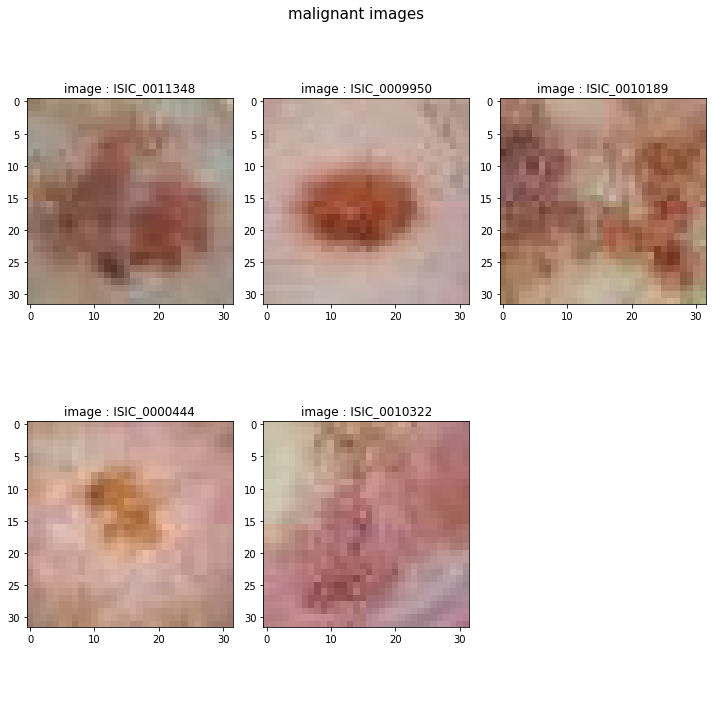

In [134]:
image_selector("malignant", 5)

#### 1.3 From the training image set, load five benign cases and display their images. (10 points)

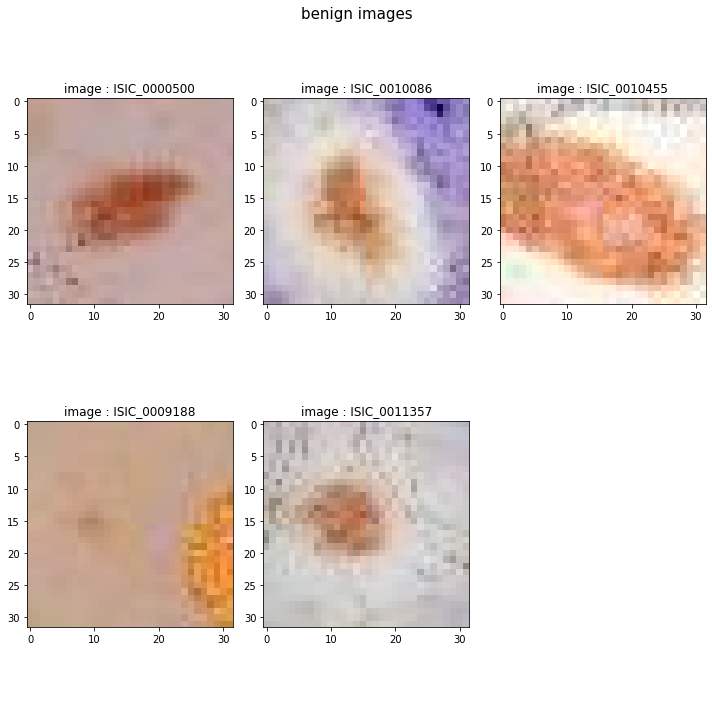

In [135]:
image_selector("benign", 5)

#### 1.4 Pick one image and show the three channels (R-G-B) of the image separately. (10 points)

Hint: An RGB image is an array of size X x Y x C, where C = 3, standing for respectively red, green and blue channels. You can use `Reds_r`, `Greens_r`, `Blues_r` as the cmap (colormap) for each channel when you plot the images.

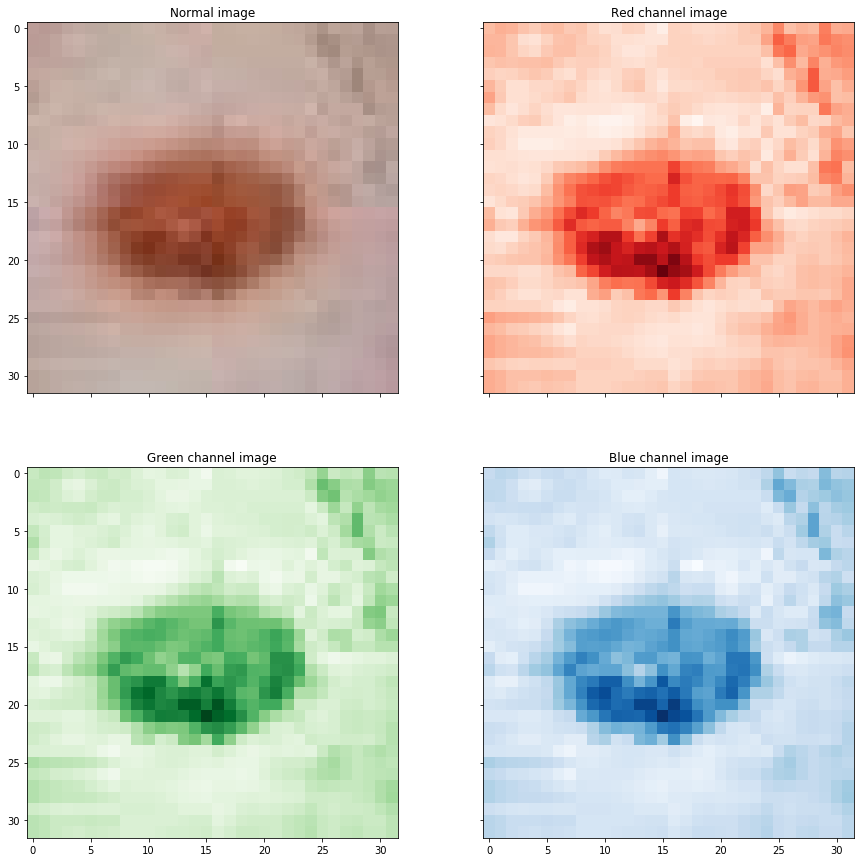

In [24]:
#select image
image_n="ISIC_0009950.jpg"
#create image np array:
image = imageio.imread("training/"+image_n)
#intensity array:
lum_img = image[:, :, 0]


fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15,15))
ax1.imshow(image)
ax1.set_title("Normal image")
ax2.imshow(lum_img, cmap="Reds_r")
ax2.set_title("Red channel image")
ax3.imshow(lum_img, cmap="Greens_r")
ax3.set_title("Green channel image")
ax4.imshow(lum_img, cmap="Blues_r")
ax4.set_title("Blue channel image")

for ax in fig.get_axes():
    ax.label_outer()

#### 1.5 Show the intensity histogram of the image. (5 points)

Hint: Flatten the image to a vector, then use the appropriate histogram function in Python.

Text(0, 0.5, 'Count')

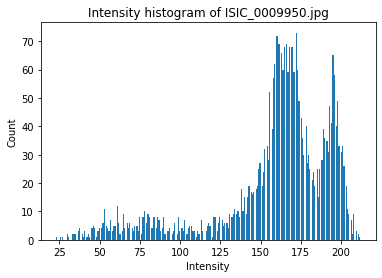

In [25]:
image_vector=image.flatten()

plt.hist(image_vector, bins=250)
plt.title("Intensity histogram of {}".format(image_n))
plt.xlabel("Intensity")
plt.ylabel("Count")

## 2. Analyse data.

Here, you need to train a classification model on the training set, then apply it to the test set. Most [sklearn](https://scikit-learn.org) classifiers require two inputs for training a model, respectively features X and labels y.

X: N x M matrix, N denoting the number of samples, M denoting the number of features for each sample.

y: N x 1 vector, each element recording the label of a sample.

#### 2.1 Prepare the training data according to the above description, using variable names X_train and y_train. Print out the shapes, i.e. dimensions, of X_train and y_train. (10 points)

In [26]:
def get_data2(path, label_df):
    all_images_as_array=[]
    label=[]
    for filename in os.listdir(path):
        img = imageio.imread(path+filename)
        np_array = np.asarray(img)
        l,b,c = np_array.shape
        np_array = np_array.reshape(l*b*c,)
        all_images_as_array.append(np_array)
        for index, row in label_df.iterrows():
            if filename[:12]==row["Unnamed: 0"]:
                if row["label"]=="malignant":
                    label.append(1)
                else:
                    label.append(0)
         

    return np.array(all_images_as_array), np.array(label)



In [27]:
path_to_train_set = "training/"
X_train,y_train = get_data2(path_to_train_set,y_train_df)
print('X_train set : ',X_train)
print('y_train set : ',y_train)

X_train set :  [[146 130 107 ... 166 144 121]
 [ 47  18  20 ... 106  84  87]
 [183 176 183 ... 132  86  70]
 ...
 [209 208 188 ... 197 200 173]
 [193 183 184 ... 192 198 184]
 [226 206 181 ... 209 207 194]]
y_train set :  [0 1 0 0 0 0 0 0 0 1 1 0 0 0 1 0 1 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 1 0 0 1 1 0 0 0 1 0 0 1 0 0 0 0 1 1 0 0 0 0 0 0 0 1 1 0 0 0 0 0 1 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1 1 0 0 0 0 0 0 0 1 0 1 0
 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0 0 1 0 0 0 1 1 0 0 1 0 1 0
 0 0 0 0 1 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 1 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 1 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0
 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 1 0 0 0 0 1 0
 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0

In [28]:
print("The shape of the shape of the X_train set is: {} and the shape of the y_train is: {}.".format(X_train.shape, y_train.shape))

The shape of the shape of the X_train set is: (600, 3072) and the shape of the y_train is: (600,).


#### 2.2 Similarly, prepare the test data according, using variable names X_test and y_test. Print out the shapes of X_test and y_test. (10 points)

In [29]:
path_to_test_set = "test/"
X_test, y_test = get_data2(path_to_test_set, y_test_df)
print('X_test set : ',X_test)
print('y_test set : ',y_test)

X_test set :  [[200 147 165 ... 199 140 146]
 [151 117 105 ... 149 108 106]
 [146 128 124 ... 140 134 120]
 ...
 [197 179 157 ... 210 189 172]
 [168 210 248 ... 183 230 255]
 [243 226 216 ... 227 213 210]]
y_test set :  [0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 1 0 0 1 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1
 0 0 0 0 1 1 1 0 1 0 0 0 0 0 1 0 0 1 1 0 1 0 1 0 0 0 1 0 0 0 0 0 1 0 0 1 0
 1 0 0 0 1 0 0 0 1 0 0 1 0 1 0 0 0 0 0 0 1 0 1 0 0 1 0 1 0 0 0 0 1 0 0 0 0
 0 0 0 0 0 0 0 1 0 0 0 1 1 0 0 0 0 0 0 0 1 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0
 0 0 1 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 1 0 0 0 0
 0 0 1 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 1 0 1 0 1 0 1 0 0 0 0 1 0 0 1 1 0 0 0
 1 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 1 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1]


In [30]:
print("The shape of the shape of the X_test set is: {} and the shape of the y_test is: {}.".format(X_test.shape, y_test.shape))

The shape of the shape of the X_test set is: (300, 3072) and the shape of the y_test is: (300,).


#### 2.3 Train a classification model on X_train and y_train. (10 points)

Hint: You only need to train one model. You can use any classification model supported by sklearn, including

* [K nearest neighbour classifier](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.neighbors)
* [Random forest classifier](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.ensemble)
* [Support vector machine classifier](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.svm)
* or any other models

In [31]:
#K nearest neighbour classifier with 3 neighbors:
import time as time
model=neighbors.KNeighborsClassifier(3)
start_time=time.time()
model.fit(X_train, y_train)
print((time.time() - start_time), "seconds")

0.08041024208068848 seconds


In [32]:
#Random forest classifier with 20 trees
model_rf=ensemble.RandomForestClassifier(20)
start_time=time.time()
model_rf.fit(X_train, y_train)
print((time.time() - start_time), "seconds")

0.36365699768066406 seconds


In [35]:
#Support vector machine classifier
model_svm=svm.SVC(kernel="poly")
start_time=time.time()
model_svm.fit(X_train, y_train)
print((time.time() - start_time), "seconds")

/Users/anaraquelpengelly/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


0.8471097946166992 seconds


#### 2.4 Apply the model on the test set X_test to predict the labels. (5 points)

In [36]:
#K nearest neighbour classifier 
start_time=time.time()
y_pred=model.predict(X_test)
print((time.time()-start_time), "seconds")

0.8429350852966309 seconds


In [37]:
#Random forest classifier 
start_time=time.time()
y_pred_rf=model_rf.predict(X_test)
print((time.time()-start_time), "seconds")

0.008184194564819336 seconds


In [38]:
#SVM
start_time=time.time()
y_pred_svm=model_svm.predict(X_test)
print((time.time()-start_time), "seconds")

0.3049910068511963 seconds


#### 2.5 Display the [confusion matrix](https://scikit-learn.org/stable/modules/model_evaluation.html#classification-metrics) of the prediction results. (5 points)

Hint: You can find an [implementation](https://scikit-learn.org/stable/modules/model_evaluation.html#classification-metrics) in sklearn.

In [39]:
print("The accuracy for the k nearest neighbour classifier is {}%.".format(round(metrics.accuracy_score(y_test, y_pred, normalize=False)/len(y_test)*100, 2)))

The accuracy for the k nearest neighbout method is 78.33%.


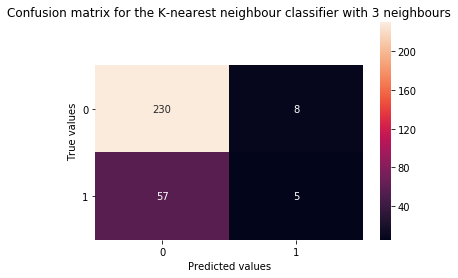

In [47]:
import seaborn as sns
conf_met_NN=metrics.confusion_matrix(y_test, y_pred)
ax= plt.figure()
ax=sns.heatmap(conf_met_NN, annot=True, fmt="g")
ax.set(ylim=(2,-0.5), xlabel="Predicted values", ylabel="True values", title="Confusion matrix for the K-nearest neighbour classifier with 3 neighbours")
ax.set_yticklabels(labels=ax.get_yticklabels(), rotation=0)
plt.show()


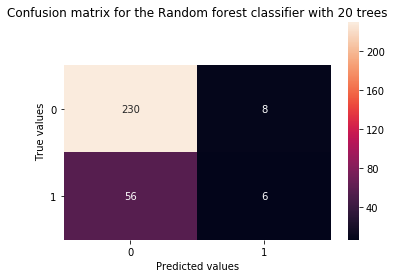

In [48]:
#Random forest classifier

conf_rf=metrics.confusion_matrix(y_test, y_pred_rf)

ax= plt.figure()
ax=sns.heatmap(conf_rf, annot=True, fmt="g")
ax.set(ylim=(2,-0.5), xlabel="Predicted values", ylabel="True values", title="Confusion matrix for the Random forest classifier with 20 trees")
ax.set_yticklabels(labels=ax.get_yticklabels(), rotation=0)
plt.show()


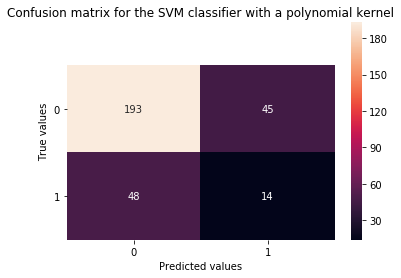

In [49]:
#SVM
conf_svm=metrics.confusion_matrix(y_test, y_pred_svm)
ax= plt.figure()
ax=sns.heatmap(conf_svm, annot=True, fmt="g")
ax.set(ylim=(2,-0.5), xlabel="Predicted values", ylabel="True values", title="Confusion matrix for the SVM classifier with a polynomial kernel")
ax.set_yticklabels(labels=ax.get_yticklabels(), rotation=0)
plt.show()



#### 2.6 Explain how many malignant cases there are in the test set and how many are correctly predicted. (10 points)

In [52]:
print("According to the confusion matrix there are {} malignant cases in the test set and {} cases were correctly \npredicted by the Knearest neighbour classifier with 3 neighbours.".format(sum(conf_met_NN[1]),conf_met_NN[1,1]))

According to the confusion matrix there are 62 malignant cases in the test set and 5 cases were correctly 
predicted by the Knearest neighbour classifier with 3 neighbours.


In [56]:
print("The classifer that predicts the most malignant cases is the SVM classifier with a polynomial kernel.\nIt predicts {} malignant cases.".format(conf_svm[1,1]))

The classifer that predicts the most malignant cases is the SVM classifier with a polynomial kernel.
It predicts 14 malignant cases.


#### Survey: How long does it take you to complete this coursework?

In [57]:
print("It took me approximately 3 hours to finish and a couple of hours to polish.")

It took me approximately 3 hours to finish and a couple of hours to polish.
